I collaborated with Eric Cho to write this post. Given the a universe of N stocks with expected returns of μ and covariance matrix Σ, mean-variance portfolio problem can be defined as follows:

$$\underset{\mathbf{w}}{\text{min}} \mathbf{w}'\mathbf{\Sigma}\mathbf{w} $$
where $w'\mathbf{1}=1$ and $w'\mu=z$. Here w is weights of the portfolio and z is the required return on the portfolio. This problem has a well-known solution.
$$w=\frac{C − zB}{AC − B^2}{\Sigma}^{-1}\mathbf{1}+\frac{zA − B}{AC − B^2}{\Sigma}^{-1}\mu$$
Despite the analytical solution to the problem, implementing optimal mean-variance portfolio in real-world is difficult because true expected returns and covariance matrix is hard to measure. I will explore using reinforcement learning to tackle the mean-variance portfolio problem.

The reinforcement learning algorithm used in this post is Deep Q-Network (DQN).Instead of the mean-variance portfolio problem, I look at mean returns and variance / covariances among different stocks as features.

In [1]:
import pandas as pd
from keras.callbacks import TensorBoard
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import TensorBoard
from collections import deque
import numpy as np
import random
from tqdm import tqdm
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
%matplotlib inline


For this analysis, I will use the RL_stock_prices.csv, which is uploaded in my repository. I randomly choose 3 stocks from Korea’s KOSPI index and look at daily prices 2010-01-01 ~ 2019-12-31. The three randomly picked stocks are 089470.KS - HDC Hyundai Engineering Plastic Co, 031440.KS - Shinsegae Food Co, and 012030.KS - DB Inc. The stock returns data can be found here. P1,P2, and P3 are the adjusted closing prices of 089470.KS, 031440.KS, and 012030.KS respectively. The stock price data is sourced from FN Guide. As the first step, I need to build the relevant features.

In [2]:
df = pd.read_csv(r"C:\Users\minho\Documents\RL_stock_prices.csv")
df[['R1','R2','R3']] = df[['P1','P2','P3']]/df[['P1','P2','P3']].shift(1)-1

The mean-variance portfolio problem assumes that the stock return distribution is stationary and that $\mu$ and $\Sigma$ do not change. This is unlikely to be true in the real world where stock return distribution is likely to be time-varying. In order to capture the short-term to long-term changes in stock return distrbution, I look at 3 different windows in computing the past mean and variance/covariance.

In [3]:
window1 = 20
window2 = 50
window3 = 100
df[['M11','M12','M13']] = df[['R1','R2','R3']].rolling(window1).mean()
df[['M21','M22','M23']] = df[['R1','R2','R3']].rolling(window2).mean()
df[['M31','M32','M33']] = df[['R1','R2','R3']].rolling(window3).mean()
for i in range(1,4):
    for j in range(i,4):
        df[f'V1{i}{j}'] = df[f'R{i}'].rolling(window1).cov(df[f'R{j}'])
        df[f'V2{i}{j}'] = df[f'R{i}'].rolling(window2).cov(df[f'R{j}'])
        df[f'V3{i}{j}'] = df[f'R{i}'].rolling(window3).cov(df[f'R{j}'])

Below is the ModifiedTensorBoard class taken from pythonprogramming.net, which allows custom documentation of different training parameters across different epochs.



In [4]:
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        #self.writer = tf.summary.FileWriter(self.log_dir)
        self.writer = tf.summary.create_file_writer(self.log_dir)
    def set_model(self, model):
        pass

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, n

    # Overriding this method to stop creating default log writero need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)

    def _write_logs(self, logs, index):
        with self.writer.as_default():
            for name, value in logs.items():
                tf.summary.scalar(name, value, step=index)
                self.step += 1
                self.writer.flush()
#    def update_stats(self, **stats):
#        self._write_logs(stats, self.step)

Below is the class function for DQNAgent. The core of DQN is Q-learning, which is a model-free reinforcement learning algorithm. It roots from state-action value function, also known as Q-function. The Q-function is defined as follows

$$Q(s,a)=\mathop{\mathbb{E}}_{\pi}[\sum_{k=0}^\infty \gamma^{k}r_{t+k+1}|s_t=s,a_t=a]$$
Intuitively, Q-function defines an intertemporal value of taking a policy π. If the policy is to always take the optimal action, the Q-function can be recursively written down as

$$Q(s_t,a_t)=r(s_t,a_t),+\gamma\underset{a}{\text{max}}Q(s_{t+1},a)$$
The goal of Q-learning is to find a stable Q-function. This is done through value iteration method

$$Q_{i+1}(s_t,a_t)=Q_i(s_t,a_t)+\alpha(r(s_t,a_t)+\gamma\underset{a}{\text{max}}Q^∗(s_{t+1},a)−Q_i(s_t,a_t))$$
Here $Q_i$ is ith iteration estimation of Q-function and $Q^∗$ is the best estimate of Q-function. DQN uses deep learning to estimate the Q-function. To effectively train the deep learning model, DQN contains two main features

1. Experience Replay
2. Target Network

Instead of fitting deep learning model on the entire past data, Experience Replay trains the model in random sample of past data, which reduces chances of overfitting and allows faster training. In my exercise, I used 10,000 replay memory size, 100 minimum replay memory size, and training size( minibatch size) of 64.

Target Network is the concept of updating $Q^∗$ less frequently. By keeping $Q^∗$ more stable, $Q_i$ can be learned in a more stable manner. In my exercise, I update $Q^∗$ every 5 iterations.

In [5]:
class DQNAgent:
    def __init__(self, state_size, replay_memory_size = 10000, min_replay_memory_size = 100, minibatch_size=64, discount = 0.99, update_every = 5):
        #Default Params
        self.state_size = state_size
        self.replay_memory_size = replay_memory_size
        self.min_replay_memory_size = min_replay_memory_size
        self.minibatch_size = minibatch_size
        self.discount = discount
        self.update_every = update_every
        
        self.model = self.create_model()

        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/mean_variance")

        self.replay_memory = deque(maxlen=self.replay_memory_size)

        self.target_update_counter = 0
    
    def create_model(self):
        model = Sequential()
        model.add(Dense(units=100, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=100, activation="relu"))
        model.add(Dense(units=100, activation="relu"))
        model.add(Dense(15, activation="linear"))
        model.compile(loss=huber_loss, optimizer=Adam(lr=0.001))
        return model
        
    def act(self, state):
        state = np.array(state)
        predicted_qs = self.model.predict(state.reshape(-1,self.state_size))[0]
        return np.argmax(predicted_qs)  
        
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def train(self, terminal_state):
        if len(self.replay_memory)<self.min_replay_memory_size:
            return
        
        minibatch = random.sample(self.replay_memory, self.minibatch_size)
        current_states = np.array([transition[0] for transition in minibatch])
        
        current_qs_list = self.target_model.predict(current_states)
        
        new_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_states)
        
        X,y = [],[]
        
        for index, (current_state, action, reward, new_state, done) in enumerate(minibatch):
            max_future_q = np.max(future_qs_list[index])
            if done:
                new_q = reward
            else:
                new_q = reward + self.discount * max_future_q
        
            current_qs = current_qs_list[index]
        
            current_qs[action] = new_q
        
            X.append(current_state)
            y.append(current_qs)
        
        self.model.fit(np.array(X), np.array(y), batch_size = self.minibatch_size, verbose = 0, epochs = 0, shuffle = False, callbacks = None)
        
        
        if terminal_state:
            self.target_update_counter +=1
        
        if self.target_update_counter>self.update_every:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0


One of the main design choices of DQN is the deep learning model architecture. While many studies in using Reinforcement Learning for trading uses more complicated form of networks such as Convolutional Neural Network (CNN) and Recurrent Neural Network (RNN), since the analytical solution to mean-variance portfolio problem is a simple function of $\Sigma$ and $\mu$, I focus on simple neural network consisting of dense layers as in create_model function. For the loss function, I decided to use Huber Loss function, which I found to be better at fitting in this setup. The code from loss function is derived from 
https://becominghuman.ai/beat-atari-with-deep-reinforcement-learning-part-2-dqn-improvements-d3563f665a2c

In [6]:
def huber_loss(a, b, in_keras=True):
    error = a - b
    quadratic_term = error*error / 2
    linear_term = abs(error) - 1/2
    use_linear_term = (abs(error) > 1.0)
    if in_keras:
        use_linear_term = K.cast(use_linear_term, 'float32') # Keras won't let us multiply floats by booleans, so we explicitly cast the booleans to floats
    return use_linear_term * linear_term + (1-use_linear_term) * quadratic_term

Now that DQNAgent class is done, instance of it can be created. As described previously, this exercise will use $\mu$ and $\Sigma$ estimated at different frequencies as featuers.

In [7]:
dt = df.iloc[window3:].reset_index(drop = True)
train_dt = dt.loc[dt['tradedate']<"2019-01-01"].reset_index(drop = True)
test_dt = dt.loc[dt['tradedate']>="2019-01-01"].reset_index(drop = True)

features = [c for c in df.columns if c[0] in ['M','V']]

agent = DQNAgent(len(features)+2)

The next part is training the DQNAgent. One limitation of DQN algorithm is that the action space has to be discrete and finite. For this, I discretize the action space (weights to be placed on each stocks) into a space of 15 actions. Namely, I place a restriction that each stock can only have weights in the multiple of 25%.

Although the original mean-variance portfolio problem attempts to solve minimization problem with the constraint that the mean return be equal to a pre-defined number, it isn’t clear how this constraint can be enforced in DQN context. Even in Ledoit, Wolf (2003), an influential work on empirically estimating $\Sigma$ through shrinkage, mean return is ignored when testing for out of sample performance. This exercise enforces reward function based on portfolio variance.

To prevent overfitting, I randomly pick a sub-period of 1000 trading days on each episode of training.

In [8]:
#Training Variables
epsilon = 0.8
N_EPISODES = 1000
MIN_EPSILON = 0.05
EPSILON_DECAY = 0.995
EPISODE_LENGTH = 1000
AGGREGATE_STATS_EVERY=5 #Update tensorboard every 5 episodes

weight_map = [[0,0,4],[1,0,3],[2,0,2],
[3,0,1],[4,0,0],[0,1,3],[1,1,2],[2,1,1],
[3,1,0],[0,2,2],[1,2,1],[2,2,0],[0,3,1],
[1,3,0],[0,4,0]]


ep_rewards = [] #History of episode rewards

for episode in tqdm(range(1, N_EPISODES + 1), ascii=True, unit = "episode"):
    agent.tensorboard.step = episode
    episode_st_idx = np.random.randint(len(train_dt) - EPISODE_LENGTH)
    episode_dt = train_dt.iloc[episode_st_idx:episode_st_idx+EPISODE_LENGTH].reset_index(drop=True)
    
    ret_history = [] #History of portfolio returns
    
    current_state = [0]*(len(features)+2) #initialize state variable with 0s
    episode_reward = 0
    
    for idx,d in episode_dt.iterrows():
        #Epsilon greedy algorithm. Choose random action if random number less than epsilon 
        if np.random.random()<=epsilon:
            action = np.random.randint(0,15)
        else:
            action =  agent.act(current_state)
        
        #Map action to portfolio weights
        weights = np.array(weight_map[action])/4
                
        #Process action
        ret_history.append(sum(weights*d[['R1','R2','R3']]))
        reward = 0

        if idx == EPISODE_LENGTH-1:
            done = True
            reward = -np.var(ret_history)
        else:
            done = False
        episode_reward += reward
        new_state = [np.var(ret_history), idx/EPISODE_LENGTH] + list(d[features])
        
        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done)
        
        #Update current state with new state        
        current_state = new_state 
        
    #Update Tensorboard
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)
    
    #Decay epsilon every episode
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

agent.model.save_weights("trained_model")

100%|######################################################################| 1000/1000 [27:16:54<00:00, 98.21s/episode]


Now let's try deploying the model to out of sample data.

In [9]:
#load Trained Model
agent.model.load_weights("trained_model")

#initialize variables
current_state = [0]*(len(features)+2)
weight_history = []
ret_history = []

EPISODE_LENGTH = len(test_dt)
for idx,d in test_dt.iterrows():    
    action =  agent.act(current_state)

    #Map action to portfolio weights
    weights = np.array(weight_map[action])/4
    weight_history.append(weights)

    #Process action
    ret_history.append(sum(weights*d[['R1','R2','R3']]))
    reward = 0

    if idx == EPISODE_LENGTH-1:
        done = True
        reward = -np.var(ret_history)
    else:
        done = False
    episode_reward += reward
    new_state = [np.var(ret_history), idx/EPISODE_LENGTH] + list(d[features])
    
    current_state = new_state
print("Portfolio Variance:", -reward)
print("S1 Variance:", np.var(test_dt['R1']))
print("S2 Variance:", np.var(test_dt['R2']))
print("S3 Variance:", np.var(test_dt['R3']))


Portfolio Variance: 0.0002162661464555882
S1 Variance: 0.00039278878062088676
S2 Variance: 0.0002475167239713626
S3 Variance: 0.00031164781447791775


It appears portfolio variance by DQN agent has lower variance than any of the singular stock variance.



<AxesSubplot:>

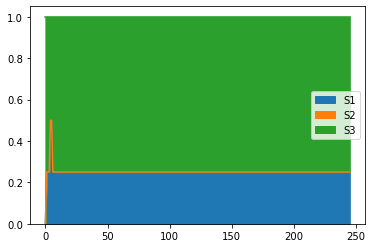

In [10]:
weight_df = pd.DataFrame(weight_history, columns = ["S1","S2","S3"])
weight_df.plot.area()

Looking at weights chosen by the DQN agent, 50%, 25%, 25% is chosen for each stocks. This is close to the portfolio weights using shrinkage estimator when the lagrangian to the mean return is approximately 2. 
$$\gamma=\frac{zA−B}{AC−B^2}⟹z=\frac{\gamma(AC−B^2)+B}{A}$$

In [11]:
mu = train_dt[['R1','R2','R3']].apply(lambda x: np.mean(x), axis = 0)
Sigma = LedoitWolf().fit(train_dt[['R1','R2','R3']]).covariance_
Sigma_inv = np.linalg.inv(Sigma)

A = np.matmul(np.matmul(np.transpose(np.ones(3)), Sigma_inv), np.ones(3))
B = np.matmul(np.matmul(np.transpose(mu), Sigma_inv), np.ones(3))
C = np.matmul(np.matmul(np.transpose(mu), Sigma_inv), mu)

gamma = 2
z = (gamma*(A*C-B**2)+B)/A

optimal_weight = (C - z*B)/(A*C-B**2)*np.matmul(Sigma_inv,np.ones(3)) + (z*A - B)/(A*C-B**2)*np.matmul(Sigma_inv, mu)
print(optimal_weight)

[0.55581637 0.24408406 0.20009957]
